
-----
#### MS: Unique patterns of mutations in childhood cancer highlight chemotherapy’s disease-defining role at relapse
### Main Figure 2
-----

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import rankdata, f_oneway
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

import warnings
warnings.filterwarnings('ignore')

-----
##### Set up input / output directories

In [2]:
## Provide an output directory for figures or use 'installation_folder/figures' directory
root_dir = os.path.dirname(os.getcwd())
fig_out = os.path.join(root_dir, 'figures')
## Or provide a results path
#fig_out = '/Users/dir1/dir2/Figures'

In [3]:
root_dir

'/Users/mehdi/Documents/MyRepos/mutsigs_therapy'

-----
##### Load helper scripts

In [4]:
sys.path.append(str(root_dir))
import scripts.plotter as plotter
import scripts.utils as ut
import scripts.ml_utils as mu

-----
##### Load & prepare data 

In [5]:
## Load patients metadata
kzm611_md = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_md.tsv'), sep='\t', index_col=0)
kzm611_md['TMB'] = kzm611_md[['SBS', 'DBS', 'ID']].sum(axis=1)

low_samples = kzm611_md[kzm611_md.Burden=='low'].index.tolist()

In [19]:
kzm_tmb = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_TMBs.txt'), sep='\t', index_col=0)
kzm_tmb.tail(2)

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB
IID_H158271_T01_01_WG01,Female,Primary-Naive,NBL,441.0,0.49344,770,5,85,5.0,26.0,860
IID_H158493_T01_01_WG01,Male,Primary-Treated,OST,5957.0,0.56608,5037,47,654,262.0,169.0,5738


In [47]:
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].SBS.mean(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS.mean(), \
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].SBS.median(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS.median()

(8499.153846153846, 12045.6484375, 1824.0, 4751.5)

In [50]:
kzm_tmb[kzm_tmb.Thr_State=='Primary-Naive'].SBS.mean(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS.mean(), \
kzm_tmb[kzm_tmb.Thr_State=='Primary-Naive'].SBS.median(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS.median()

(44714.71887550201, 12045.6484375, 2102.0, 4751.5)

In [48]:
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].DBS.mean(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].DBS.mean(), \
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].DBS.median(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].DBS.median()

(191.30769230769232, 100.57421875, 9.0, 40.0)

In [49]:
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].ID.mean(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].ID.mean(), \
kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].ID.median(), kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].ID.median()

(1097.4615384615386, 3489.84765625, 350.0, 596.5)

In [40]:
import scipy.stats as stats

stats.ttest_ind(kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].SBS, kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS)

TtestResult(statistic=-0.31745385596385384, pvalue=0.7511473577166596, df=267.0)

In [37]:
ranksums(kzm_tmb[kzm_tmb.Thr_State=='Advanced-Naive'].SBS, kzm_tmb[kzm_tmb.Thr_State=='Advanced-Treated'].SBS)

RanksumsResult(statistic=-1.8052777564069682, pvalue=0.07103122859545713)

In [7]:
kzm_tmb.SV.sum(), kzm_tmb.SV.min(), kzm_tmb.SV.max(), 1/2897.310462, 1472/2897.310462

(46324.0, 1.0, 1472.0, 0.0003451476854536689, 0.5080573929878006)

In [9]:
kzm_tmb.CN.sum(), kzm_tmb.CN.min(), kzm_tmb.CN.max(), kzm_tmb.CN.min()/2897.310462, kzm_tmb.CN.max()/2897.310462

(84119.0, 1.0, 4900.0, 0.0003451476854536689, 1.6912236587229774)

In [ ]:
'''kzm_tmb = kzm_tmb[kzm_tmb.Thr_State.isin(['Primary-Naive', 'Advanced-Treated'])]
kzm_tmb['Sex_bin'] = [0 if x=='Female' else 1 for x in kzm_tmb.Sex]
kzm_tmb['State_bin'] = [0 if x=='Primary-Naive' else 1 for x in kzm_tmb.Thr_State]
#kzm_tmb = kzm_tmb.dropna(axis=0)
kzm_tmb.head(3)'''

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin
KiCS0002_321321,Female,Advanced-Treated,GCT,6223.0,0.98,15207.0,403.0,1117.0,257.0,51.0,16727.0,0,1
KiCS0003_285201,Female,Advanced-Treated,MFT,922.0,0.30,1596.0,7.0,175.0,52.0,25.0,1778.0,0,1
KiCS0003_285202,Female,Advanced-Treated,MFT,1374.0,0.29,3670.0,20.0,396.0,37.0,4.0,4086.0,0,1


In [18]:
kzm_tmb.tail()

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin
IID_H158186_T02_01_WG01,Female,Advanced-Treated,NBL,5550.0,0.32416,174714.0,94.0,24232.0,15.0,29.0,199040.0,0
IID_H158223_T01_01_WG01,Female,Advanced-Treated,OST,5646.0,0.87957,8528.0,183.0,762.0,313.0,201.0,9473.0,0
IID_H158271_T01_01_WG01,Female,Primary-Naive,NBL,441.0,0.49344,770.0,5.0,85.0,5.0,26.0,860.0,0
IID_H158493_T01_01_WG01,Male,Primary-Treated,OST,5957.0,0.56608,5037.0,47.0,654.0,262.0,169.0,5738.0,1
KiCS0310_19-15652-A-02-00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,1


In [31]:
kzm_tmb.Thr_State.value_counts()

Thr_State
Advanced-Treated    256
Primary-Naive       249
Primary-Treated      93
Advanced-Naive       13
Name: count, dtype: int64

In [20]:
kzm_tmb['Sex_bin'] = [0 if x=='Female' else 1 for x in kzm_tmb.Sex]
state_dict = {'Primary-Naive': 0, 'Primary-Treated': 1, 'Advanced-Naive': 2, 'Advanced-Treated': 3}
kzm_tmb['State_bin'] = [state_dict[x] for x in kzm_tmb.Thr_State.tolist()]

In [23]:
def ranked_ancova_v1(kzm_tmb, mut_type='SBS'):
    df = kzm_tmb[['State_bin', 'Age_days', 'Sex_bin', 'Purity', mut_type]]
    df = df.dropna(axis=0)
    # Step 1: Rank the Dependent Variable
    df['RankedTMB'] = rankdata(df[mut_type])

    # Step 2: Regress Out Covariates (Age and Sex) from Ranked Data
    X = df[['Age_days', 'Sex_bin', 'Purity']]
    y = df['RankedTMB']

    # Fit linear regression on covariates
    reg = LinearRegression().fit(X, y)
    df['ResidualRanks'] = y - reg.predict(X)  # Residuals of ranked data

    # Step 3: Test Group Differences on Residuals
    group_0 = df[df['State_bin'] == 0]['ResidualRanks']
    group_1 = df[df['State_bin'] == 1]['ResidualRanks']

    # Perform an F-test on residual ranks (nonparametric equivalent of ANCOVA)
    f_stat, p_value = f_oneway(group_0, group_1)

    print(f"====== Ranked ANCOVA ======")
    print(f"====================== {mut_type}")
    print(f"F-Statistic: {f_stat}, P-Value: {p_value}")
    return df, p_value

from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway, rankdata
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

def ranked_ancova_4groups(data, group_col='State_bin', mut_type='SBS'):
    df = data[[group_col, 'Age_days', 'Sex_bin', 'Purity', mut_type]].dropna()
    
    # Step 1: Rank the dependent variable
    df['RankedTMB'] = rankdata(df[mut_type])

    # Step 2: Regress out covariates (Age, Sex, Purity) from ranked data
    X = df[['Age_days', 'Sex_bin', 'Purity']]
    y = df['RankedTMB']
    reg = LinearRegression().fit(X, y)
    df['ResidualRanks'] = y - reg.predict(X)

    # Step 3: Group residuals by unique group labels
    groups = df[group_col].unique()
    grouped_values = [df[df[group_col] == g]['ResidualRanks'] for g in groups]

    # Perform one-way ANOVA across the groups
    f_stat, p_value = f_oneway(*grouped_values)

    # Results
    print("====== Ranked ANCOVA ======")
    print(f"Dependent Variable: {mut_type}")
    print(f"Groups: {groups}")
    print(f"F-Statistic: {f_stat:.4f}, P-Value: {p_value:.4e}")

    # Step 4: Post hoc test (Tukey HSD)
    if len(groups) > 2 and p_value < 0.05:
        print("\nPost Hoc Test (Tukey's HSD):")
        tukey = pairwise_tukeyhsd(endog=df['ResidualRanks'], groups=df[group_col], alpha=0.05)
        print(tukey.summary())

    return df, p_value


In [102]:
from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway, rankdata, ranksums
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np

def ranked_ancova_4groups(data, group_col='State_bin', mut_type='SBS'):
    df = data[[group_col, 'Age_days', 'Sex_bin', 'Purity', mut_type]].dropna()

    # Step 1: Rank the dependent variable
    df['RankedTMB'] = rankdata(df[mut_type])

    # Step 2: Regress out covariates (Age, Sex, Purity) from ranked data
    X = df[['Age_days', 'Sex_bin', 'Purity']]
    y = df['RankedTMB']
    reg = LinearRegression().fit(X, y)
    df['ResidualRanks'] = y - reg.predict(X)

    # Step 3: Group residuals by unique group labels (sorted)
    groups = sorted(df[group_col].unique())
    grouped_values = [df[df[group_col] == g]['ResidualRanks'] for g in groups]

    # Perform one-way ANOVA across the groups
    f_stat, p_value = f_oneway(*grouped_values)

    # Print ANOVA results
    print("====== Ranked ANCOVA ======")
    print(f"Dependent Variable: {mut_type}")
    print(f"Groups: {groups}")
    print(f"F-Statistic: {f_stat:.4f}, P-Value: {p_value:.4e}")

    # If significant, do post hoc tests
    if len(groups) > 2: # and p_value < 0.05:
        print("\nPost Hoc Test (Tukey's HSD):")
        tukey = pairwise_tukeyhsd(endog=df['ResidualRanks'], groups=df[group_col], alpha=0.05)
        print(tukey.summary())

        # Pairwise Wilcoxon rank-sum tests with FDR correction
        pvals = []
        comparisons = []
        for i in range(len(groups)):
            for j in range(i+1, len(groups)):
                grp1 = df[df[group_col] == groups[i]]['ResidualRanks']
                grp2 = df[df[group_col] == groups[j]]['ResidualRanks']
                stat, p = ranksums(grp1, grp2)
                pvals.append(p)
                comparisons.append(f"{groups[i]} vs {groups[j]}")

        # Adjust p-values using Benjamini-Hochberg (FDR)
        rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

        pvals_l = []

        print("\nPairwise Wilcoxon tests with FDR correction:")
        for comp, pval_corr, rej in zip(comparisons, pvals_corrected, rejected):
            print(f"{comp}: p_adj={pval_corr:.4e}, significant={rej}")
            pvals_l.append((int(comp.split(' vs ')[0]), int(comp.split(' vs ')[1]), pval_corr))
        pvals = pd.DataFrame(pvals_l)
        pvals.columns = ['first', 'second', 'pv']

    return df, p_value, pvals


In [80]:
sbs_res, sbs_pval, sbs_pvals = ranked_ancova_4groups(kzm_tmb, mut_type='SBS')


====== Ranked ANCOVA ======
Dependent Variable: SBS
Groups: [0, 1, 2, 3]
F-Statistic: 15.4760, P-Value: 1.0370e-09

Post Hoc Test (Tukey's HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0      1  26.7923 0.4997  -22.5039  76.0885  False
     0      2  14.7277 0.9877 -100.5726  130.028  False
     0      3  93.7729    0.0   57.5989  129.947   True
     1      2 -12.0646 0.9939 -132.0432  107.914  False
     1      3  66.9807 0.0027   17.8964 116.0649   True
     2      3  79.0452 0.2901  -36.1646 194.2551  False
-------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=1.8978e-01, significant=False
0 vs 2: p_adj=9.1112e-01, significant=False
0 vs 3: p_adj=3.0524e-11, significant=True
1 vs 2: p_adj=7.9347e-01, significant=False
1 vs 3: p_adj=1.6205e-03, significant=True
2 vs 3: p_adj=1.8978e-01, signi

In [98]:
dbs_res, dbs_pval, dbs_pvals = ranked_ancova_4groups(kzm_tmb, mut_type='DBS')

====== Ranked ANCOVA ======
Dependent Variable: DBS
Groups: [0, 1, 2, 3]
F-Statistic: 24.2995, P-Value: 7.4120e-15

Post Hoc Test (Tukey's HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0      1  63.1139 0.0065   13.2176 113.0101   True
     0      2  12.9868 0.9918  -103.717 129.6906  False
     0      3 120.3527    0.0   83.7383 156.9671   True
     1      2 -50.1271  0.712 -171.5661  71.3119  False
     1      3  57.2388 0.0164    7.5571 106.9205   True
     2      3 107.3659 0.0836   -9.2463 223.9781  False
-------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=1.5120e-03, significant=True
0 vs 2: p_adj=6.7309e-01, significant=False
0 vs 3: p_adj=3.8465e-16, significant=True
1 vs 2: p_adj=3.0932e-01, significant=False
1 vs 3: p_adj=1.0177e-02, significant=True
2 vs 3: p_adj=7.3588e-02, signif

In [99]:
id_res, id_pval, id_pvals = ranked_ancova_4groups(kzm_tmb, mut_type='ID')

====== Ranked ANCOVA ======
Dependent Variable: ID
Groups: [0, 1, 2, 3]
F-Statistic: 6.4201, P-Value: 2.7662e-04

Post Hoc Test (Tukey's HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0      1 -11.7264 0.9287  -61.1911  37.7382  False
     0      2  -3.5169 0.9998 -119.2112 112.1775  False
     0      3   53.151  0.001   16.8533  89.4486   True
     1      2   8.2096 0.9981 -112.1791 128.5982  False
     1      3  64.8774 0.0041   15.6254 114.1294   True
     2      3  56.6678  0.587  -58.9358 172.2714  False
-------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=8.9122e-01, significant=False
0 vs 2: p_adj=9.1945e-01, significant=False
0 vs 3: p_adj=1.4793e-04, significant=True
1 vs 2: p_adj=9.1945e-01, significant=False
1 vs 3: p_adj=1.0776e-03, significant=True
2 vs 3: p_adj=5.8653e-01, signifi

In [43]:
tmb_res, tmb_pval = ranked_ancova_4groups(kzm_tmb, mut_type='TMB')

====== Ranked ANCOVA ======
Dependent Variable: TMB
Groups: [0, 1, 2, 3]
F-Statistic: 15.2046, P-Value: 1.5021e-09

Post Hoc Test (Tukey's HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0      1  22.9868  0.624  -26.1653   72.139  False
     0      2  14.0977 0.9891 -100.8657 129.0611  False
     0      3  92.1963    0.0   56.1279 128.2647   True
     1      2  -8.8892 0.9975 -128.5172 110.7389  False
     1      3  69.2095 0.0017   20.2687 118.1503   True
     2      3  78.0986 0.2981  -36.7746 192.9718  False
-------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=2.8586e-01, significant=False
0 vs 2: p_adj=8.7820e-01, significant=False
0 vs 3: p_adj=4.0599e-11, significant=True
1 vs 2: p_adj=8.2725e-01, significant=False
1 vs 3: p_adj=1.0197e-03, significant=True
2 vs 3: p_adj=2.8556e-01, signi

In [100]:
sv_res, sv_pval, sv_pvals = ranked_ancova_4groups(kzm_tmb, mut_type='SV')

====== Ranked ANCOVA ======
Dependent Variable: SV
Groups: [0, 1, 2, 3]
F-Statistic: 2.7502, P-Value: 4.2063e-02

Post Hoc Test (Tukey's HSD):
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0      1  23.2393  0.665  -29.2906  75.7692  False
     0      2 -32.5043 0.9103 -158.4805  93.4719  False
     0      3  39.8836 0.0415    1.0558  78.7114   True
     1      2 -55.7436 0.6906  -186.486  74.9988  False
     1      3  16.6443 0.8447  -35.6164   68.905  False
     2      3  72.3879 0.4492  -53.4763 198.2521  False
-------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=3.6808e-01, significant=False
0 vs 2: p_adj=5.1188e-01, significant=False
0 vs 3: p_adj=4.2155e-02, significant=True
1 vs 2: p_adj=3.6808e-01, significant=False
1 vs 3: p_adj=4.2630e-01, significant=False
2 vs 3: p_adj=3.6808e-01, signif

In [103]:
cnv_res, cnv_pval, cnv_pvals = ranked_ancova_4groups(kzm_tmb, mut_type='CN')

====== Ranked ANCOVA ======
Dependent Variable: CN
Groups: [0, 1, 2, 3]
F-Statistic: 1.3401, P-Value: 2.6037e-01

Post Hoc Test (Tukey's HSD):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper  reject
------------------------------------------------------
     0      1  25.1759 0.5933  -26.5868 76.9385  False
     0      2 -39.4071 0.8456 -163.3996 84.5853  False
     0      3  21.9187 0.4447  -16.0019 59.8393  False
     1      2  -64.583 0.5688 -193.4272 64.2612  False
     1      3  -3.2571 0.9985  -54.8776 48.3633  False
     2      3  61.3259 0.5793  -62.6073 185.259  False
------------------------------------------------------

Pairwise Wilcoxon tests with FDR correction:
0 vs 1: p_adj=2.6574e-01, significant=False
0 vs 2: p_adj=4.9109e-01, significant=False
0 vs 3: p_adj=2.6574e-01, significant=False
1 vs 2: p_adj=2.6574e-01, significant=False
1 vs 3: p_adj=9.5566e-01, significant=False
2 vs 3: p_adj=2.6574e-01, significant=Fal

In [231]:
sbs_res, sbs_pval = ranked_ancova_v1(kzm_tmb, mut_type='SBS')
dbs_res, dbs_pval = ranked_ancova_v1(kzm_tmb, mut_type='DBS')
id_res, id_pval = ranked_ancova_v1(kzm_tmb, mut_type='ID')
tmb_res, tmb_pval = ranked_ancova_v1(kzm_tmb, mut_type='TMB')
sv_res, sv_pval = ranked_ancova_v1(kzm_tmb, mut_type='SV')
cnv_res, cnv_pval = ranked_ancova_v1(kzm_tmb, mut_type='CN')

====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 47.63326594618994, P-Value: 1.56286836808349e-11
====== Ranked ANCOVA ======
====================== DBS
F-Statistic: 76.48530283135871, P-Value: 3.394698561535289e-17
====== Ranked ANCOVA ======
====================== ID
F-Statistic: 15.518029627739102, P-Value: 9.334011388739041e-05
====== Ranked ANCOVA ======
====================== TMB
F-Statistic: 46.71184773012585, P-Value: 2.4014282489701808e-11
====== Ranked ANCOVA ======
====================== SV
F-Statistic: 7.555462941123452, P-Value: 0.006208792584560919
====== Ranked ANCOVA ======
====================== CN
F-Statistic: 2.396215267109079, P-Value: 0.12228010202933119


-----------
## Panel a

In [51]:
## Subset of metadata. Preparing df for plotting
kzm611_all = kzm_tmb.copy()
kzm611_sub = kzm_tmb.copy() #[kzm_tmb.Thr_State.isin(['Advanced-Treated', 'Primary-Naive'])]
kzm611_all.Thr_State = 'All Samples'
kzm611_mix = pd.concat([kzm611_sub, kzm611_all], axis=0)

## 2-line labels for better aesthetics
kzm611_mix['Thr_State2'] = [x.replace('-', '\n') if '-' in x else x for x in kzm611_mix.Thr_State]

In [234]:
#kzm611_mix['TMB'] = kzm611_mix[['SBS', 'DBS', 'ID']].sum(axis=1)
kzm611_mix.head()

,Sex,Thr_State,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin,Thr_State2
KiCS0002_321321,Female,Advanced-Treated,6223.0,0.98,15207.0,403.0,1117.0,257.0,51.0,16727.0,0,1,Advanced\nTreated
KiCS0003_285201,Female,Advanced-Treated,922.0,0.30,1596.0,7.0,175.0,52.0,25.0,1778.0,0,1,Advanced\nTreated
KiCS0003_285202,Female,Advanced-Treated,1374.0,0.29,3670.0,20.0,396.0,37.0,4.0,4086.0,0,1,Advanced\nTreated
KiCS0003_20_15220_A_02_00,Female,Advanced-Treated,5858.0,0.62,17044.0,58.0,2088.0,207.0,72.0,19190.0,0,1,Advanced\nTreated
KiCS0005_300238,Female,Primary-Naive,73.0,0.65,276.0,3.0,62.0,23.0,18.0,341.0,0,0,Primary\nNaive


In [54]:
## Define colors for plotting
color_dict = {'All Samples': 'white', 'Primary\nNaive': 'lightsteelblue', 'Primary\nTreated': 'mistyrose', 'Advanced\nNaive': 'lightsteelblue', 'Advanced\nTreated': 'mistyrose'}

In [96]:
from importlib import reload
reload(plotter)

<module 'scripts.plotter' from '/Users/mehdi/Documents/MyRepos/mutsigs_therapy/scripts/plotter.py'>

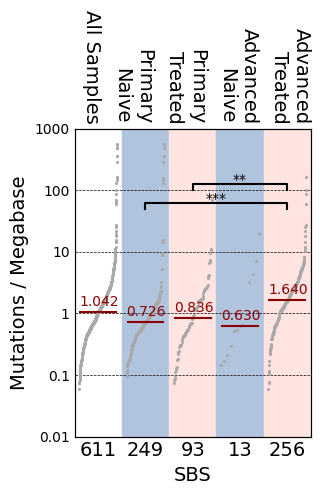

In [97]:
plotter.plotTMB_therapy_v2(kzm611_mix[['Thr_State2', 'SBS']].copy(), sbs_pvals, scale='genome',
                        color_dict=color_dict, order=['All Samples', 'Primary\nNaive', 'Primary\nTreated', 'Advanced\nNaive', 'Advanced\nTreated'],
                        xaxis="SBS", yaxis = "Mutations / Megabase", Yrange=[0.01, 1000])
plt.savefig(os.path.join(fig_out, 'Fig_2a1.pdf'), bbox_inches="tight")

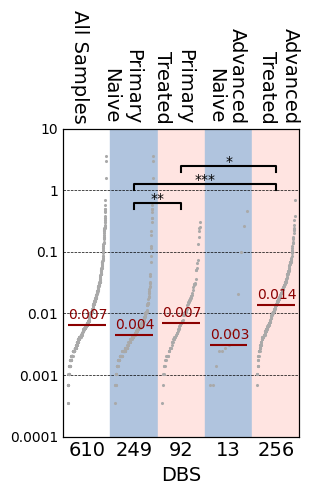

In [106]:
plotter.plotTMB_therapy_v2(kzm611_mix[['Thr_State2', 'DBS']].copy(), dbs_pvals, scale='genome', color_dict=color_dict,
                        order=['All Samples', 'Primary\nNaive', 'Primary\nTreated', 'Advanced\nNaive', 'Advanced\nTreated'],
                        xaxis="DBS", yaxis = "", Yrange=[0.0001, 10])
plt.savefig(os.path.join(fig_out, 'Fig_2a2.pdf'), bbox_inches="tight")

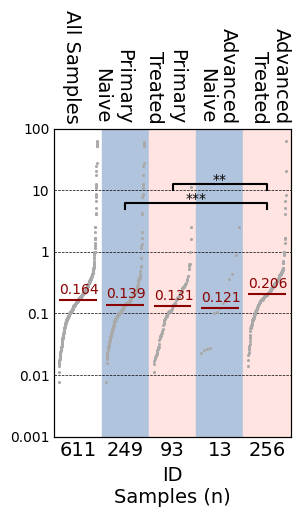

In [104]:
plotter.plotTMB_therapy_v2(kzm611_mix[['Thr_State2', 'ID']].copy(), id_pvals, scale='genome', color_dict=color_dict,
                        order=['All Samples', 'Primary\nNaive', 'Primary\nTreated', 'Advanced\nNaive', 'Advanced\nTreated'],
                        xaxis="ID\nSamples (n)", yaxis = "", Yrange=[0.001, 100])

plt.savefig(os.path.join(fig_out, 'Fig_2a3.pdf'), bbox_inches="tight")

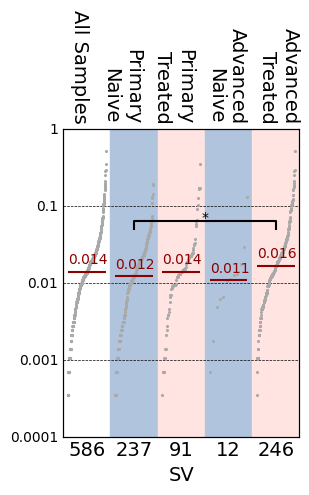

In [107]:
plotter.plotTMB_therapy_v2(kzm611_mix[['Thr_State2', 'SV']].copy(), sv_pvals, scale='genome',
                        color_dict=color_dict, order=['All Samples', 'Primary\nNaive', 'Primary\nTreated', 'Advanced\nNaive', 'Advanced\nTreated'],
                        xaxis="SV", yaxis = "", Yrange=[0.0001, 1])
plt.savefig(os.path.join(fig_out, 'Fig_2a4.pdf'), bbox_inches="tight")

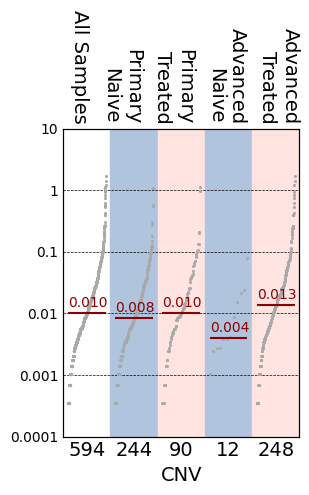

In [108]:
plotter.plotTMB_therapy_v2(kzm611_mix[['Thr_State2', 'CN']].copy(), cnv_pvals, scale='genome',
                        color_dict=color_dict, order=['All Samples', 'Primary\nNaive', 'Primary\nTreated', 'Advanced\nNaive', 'Advanced\nTreated'],
                        xaxis="CNV", yaxis = "", Yrange=[0.0001, 10])
plt.savefig(os.path.join(fig_out, 'Fig_2a5.pdf'), bbox_inches="tight")

-----------
## Panel b

In [ ]:
types10_md = kzm_tmb.copy()
types10_md['Therapy2'] = ['Naive' if x=='Primary-Naive' else 'Treated' for x in types10_md.Thr_State]
## Label aesthetics
types10_md['prepost'] = types10_md.Type + '::' + types10_md.Therapy2
types10_md = types10_md[~types10_md.prepost.isin(['HB::Treated', 'UNK::Naive', 'UNK::Treated'])]

## Get rid of any type with <5 samples either pre or post therapy
low_types = [x.split('::')[0] for x in types10_md.prepost.value_counts()[types10_md.prepost.value_counts()<5].index]
types10_md = types10_md[~types10_md.Type.isin(low_types)]
types10_md.head(2)

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin,Therapy2,prepost
KiCS0006_274243,Female,Advanced-Treated,NBL,3528.0,0.74,3842.0,30.0,180.0,28.0,17.0,4052.0,0,1,Treated,NBL::Treated
KiCS0010_270645,Male,Advanced-Treated,OST,4326.0,0.94,6761.0,51.0,1288.0,180.0,147.0,8100.0,1,1,Treated,OST::Treated


In [ ]:
## calculate medians
median_diffs = []
for t in set([x.split('::')[0] for x  in types10_md.prepost.sort_values().unique()]):
    pret_median = np.median(np.log10(types10_md[types10_md.prepost==t+'::Naive'].SBS))
    post_median = np.median(np.log10(types10_md[types10_md.prepost==t+'::Treated'].SBS))
    median_diffs.append((t, post_median - pret_median))

## Sort df based on pre-post median increase
median_diffs_sorted = sorted(median_diffs, key=lambda x: x[1])
types10_sorted = [x+'::'+y for x in [i[0] for i in median_diffs_sorted] for y in ['Naive', 'Treated']]

In [ ]:
types10_md2 = types10_md.copy()
#types10_md2['Sex'] = [0 if x=='Female' else 1 for x in types10_md2.Sex]
types10_md2['Therapy_bin'] = [0 if x=='Naive' else 1 for x in types10_md2.Therapy2]
types10_md2.head(2)

,Sex,Thr_State,Type,Age_days,Purity,SBS,DBS,ID,SV,CN,TMB,Sex_bin,State_bin,Therapy2,prepost,Therapy_bin
KiCS0006_274243,Female,Advanced-Treated,NBL,3528.0,0.74,3842.0,30.0,180.0,28.0,17.0,4052.0,0,1,Treated,NBL::Treated,1
KiCS0010_270645,Male,Advanced-Treated,OST,4326.0,0.94,6761.0,51.0,1288.0,180.0,147.0,8100.0,1,1,Treated,OST::Treated,1


In [ ]:
def ranked_ancova_type(data, mut_type='SBS'):
    df = data[['Therapy_bin', 'Age_days', 'Sex_bin', 'Purity', mut_type]]
    df = df.dropna(axis=0)
    # Step 1: Rank the Dependent Variable
    df['RankedTMB'] = rankdata(df[mut_type])

    # Step 2: Regress Out Covariates (Age and Sex) from Ranked Data
    X = df[['Age_days', 'Sex_bin', 'Purity']]
    y = df['RankedTMB']

    # Fit linear regression on covariates
    reg = LinearRegression().fit(X, y)
    df['ResidualRanks'] = y - reg.predict(X)  # Residuals of ranked data

    # Step 3: Test Group Differences on Residuals
    group_0 = df[df['Therapy_bin'] == 0]['ResidualRanks']
    group_1 = df[df['Therapy_bin'] == 1]['ResidualRanks']

    # Perform an F-test on residual ranks (nonparametric equivalent of ANCOVA)
    f_stat, p_value = f_oneway(group_0, group_1)

    print(f"====== Ranked ANCOVA ======")
    print(f"====================== {mut_type}")
    print(f"F-Statistic: {f_stat}, P-Value: {p_value}")
    return p_value


In [ ]:
pval_dict = {x: ranked_ancova_type(types10_md2[types10_md2.Type==x], mut_type='SBS') for x in list(set([y.split('::')[0] for y in types10_sorted]))}
pval_dict

====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 0.013981056690276656, P-Value: 0.9074451721646897
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 8.71684096333836, P-Value: 0.005964136224211855
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 1.8954992917235625, P-Value: 0.18308481171763255
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 21.87705367214205, P-Value: 6.215326320856459e-05
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 7.271979746302602, P-Value: 0.01831016828488064
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 0.5162832798230218, P-Value: 0.476145883863628
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 5.758613636972101, P-Value: 0.028935917957457834
====== Ranked ANCOVA ======
====================== SBS
F-Statistic: 4.840892212222991, P-Value: 0.03201123682633907
====== Ranked ANCOVA ======
====================== SBS
F-Statistic:

{'AML': 0.9074451721646897,
 'OST': 0.005964136224211855,
 'ERMS': 0.18308481171763255,
 'BALL': 6.215326320856459e-05,
 'EPD': 0.01831016828488064,
 'HGG': 0.476145883863628,
 'ARMS': 0.028935917957457834,
 'NBL': 0.03201123682633907,
 'EWS': 0.521827927111638}

Yrange is a list
ARMS
OST
BALL
EPD
NBL


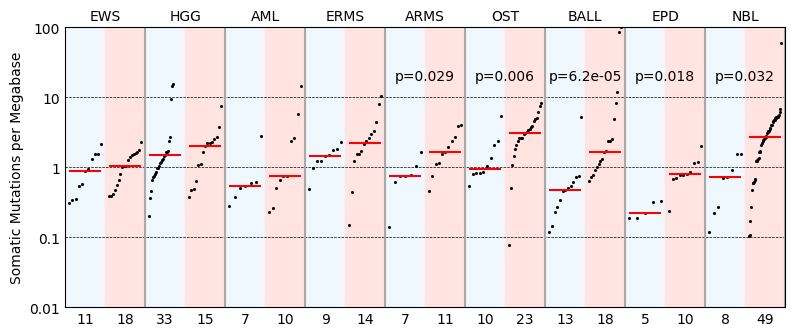

In [ ]:
#TMB_plotter.plotTMB_generic
plotter.plotTMB_type(types10_md[['prepost', 'SBS']].copy(), pval_dict, scale='genome', Yrange=[0.01, 100], order=types10_sorted)
plt.savefig(os.path.join(fig_out, 'Fig_2c.pdf'), bbox_inches="tight")

-----------
## Panel c

In [6]:
## Load the drivers df
KZM611_drivers_all = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_drivers_CosCGI.tsv'), sep='\t', index_col=0)
KZM611_drivers_low = KZM611_drivers_all[KZM611_drivers_all.Tumor_Sample_Barcode.isin(low_samples)]
KZM611_drivers_low.shape[0], KZM611_drivers_all.shape[0], KZM611_drivers_low.Tumor_Sample_Barcode.nunique(), KZM611_drivers_all.Tumor_Sample_Barcode.nunique()

(600, 1835, 314, 342)

In [34]:
KZM611_drivers_low.head(3)

,Hugo_Symbol,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_VAF,amino_acid_change,cdna,Transcript,Tumor_Sample_Barcode,mid,uid,db,driver_type
0,KMT2C,KiCS,hg19,7,151970859,151970859,Missense_Mutation,SNP,C,T,0.039,p.G315S,c.G943A,NM_170606,KiCS0148_319486,7:151970859-151970859,KiCS0148_319486_7:151970859-151970859,COSMIC,exact
1,KRAS,KiCS,hg19,12,25398285,25398285,Missense_Mutation,SNP,C,A,0.439,p.G12C,c.G34T,NM_001369786,KiCS0221_18_2564,12:25398285-25398285,KiCS0221_18_2564_12:25398285-25398285,COSMIC;CGI,exact
2,MYCN,KiCS,hg19,2,16082317,16082317,Missense_Mutation,SNP,C,T,0.460,p.P44L,c.C131T,NM_001293228,KiCS0074_302458,2:16082317-16082317,KiCS0074_302458_2:16082317-16082317,COSMIC;CGI,exact


In [35]:
driver_types = pd.read_csv('/Users/mehdi/Documents/MyRepos/KiCS/data/drivers/driver_types.txt', sep='\t')
tumor_supps = driver_types[driver_types.Category=='Tumor Suppressor Gene'].Gene.unique().tolist()
driver_types.head(3)

,Gene,Category,Notes
0,KMT2C,Tumor Suppressor Gene,Lysine Methyltransferase 2C
1,KRAS,Proto-oncogene,"KRAS Proto-Oncogene, GTPase"
2,MYCN,Proto-oncogene,"MYCN Proto-Oncogene, BHLH Transcription Factor"


In [33]:
KZM611_drivers_all[KZM611_drivers_all.driver_type=='gene_level'].shape

(829, 19)

In [38]:
drivers_ex = KZM611_drivers_all[KZM611_drivers_all.driver_type=='exact'].copy()
drivers_gl = KZM611_drivers_all[KZM611_drivers_all.driver_type=='gene_level'].copy()
print(len(drivers_gl))
drivers_gl = drivers_gl[drivers_gl.Hugo_Symbol.isin(tumor_supps)]
print(len(drivers_gl))
refined_drivers = pd.concat([drivers_ex, drivers_gl], axis=0)
refined_low = refined_drivers[refined_drivers.Tumor_Sample_Barcode.isin(low_samples)]
len(refined_drivers), len(refined_low)

829
348


(1343, 509)

In [31]:
KZM611_drivers_low.driver_type.value_counts()

driver_type
exact         390
gene_level    202
non-exact       8
Name: count, dtype: int64

In [29]:
len(KZM611_drivers_all.Hugo_Symbol.unique().tolist())

414

In [28]:
for i in range(0, len(KZM611_drivers_all.Hugo_Symbol.unique().tolist()), 50):
    print(KZM611_drivers_all.Hugo_Symbol.unique().tolist()[i:i+50])

['KMT2C', 'KRAS', 'MYCN', 'NSD2', 'PTPRT', 'PIK3R1', 'ALK', 'HRAS', 'DICER1', 'KMT2D', 'TP53', 'SPEN', 'ARID1A', 'NOTCH2', 'CDC73', 'MSH6', 'ERCC3', 'LRP1B', 'ERBB4', 'VHL', 'SETD2', 'BAP1', 'FOXP1', 'PDGFRA', 'TET2', 'FBXW7', 'APC', 'FGFR4', 'NSD1', 'FLT4', 'CARD11', 'EGFR', 'MET', 'SMO', 'FGFR1', 'MYC', 'RECQL4', 'PTCH1', 'NOTCH1', 'PTEN', 'ATM', 'KMT2A', 'SH2B3', 'PTPN11', 'POLE', 'CREBBP', 'GRIN2A', 'MAP2K4', 'NF1', 'STAT3']
['BRIP1', 'SMAD4', 'MAP2K2', 'SMARCA4', 'TMPRSS2', 'MAPK1', 'NF2', 'FLT3', 'BRAF', 'TSC2', 'H3F3A', 'CDKN2A', 'NRAS', 'KDR', 'MAP3K1', 'IKZF1', 'HNF1A', 'CTNNB1', 'PDGFRB', 'NFE2L2', 'IDH1', 'KEAP1', 'PIK3CA', 'JAK2', 'JUN', 'DNMT3A', 'XPO1', 'SF3B1', 'PBRM1', 'CACNA1D', 'ATR', 'MAP3K13', 'KIT', 'FAT1', 'LATS1', 'PPP6C', 'GATA3', 'NUP98', 'CBL', 'ERBB3', 'TBX3', 'RB1', 'CBFB', 'ZFHX3', 'SUZ12', 'RNF213', 'SETBP1', 'ERCC2', 'PPP2R1A', 'GNAS']
['RAF1', 'HLA-A', 'NUP214', 'CDK4', 'ROS1', 'HIF1A', 'RNF43', 'ASXL1', 'CDKN2C', 'BCL10', 'TENT5C', 'DDR2', 'MLH1', 'MITF

In [20]:
len(['KMT2C', 'KRAS', 'MYCN', 'NSD2', 'PTPRT', 'PIK3R1', 'ALK', 'HRAS', 'DICER1', 'KMT2D', 'TP53', 'SPEN', 'ARID1A', 'NOTCH2', 'CDC73', 'MSH6', 'ERCC3', 'LRP1B', 'ERBB4', 'VHL', 'SETD2', 'BAP1', 'FOXP1', 'PDGFRA', 'TET2', 'FBXW7', 'APC', 'FGFR4', 'NSD1', 'FLT4', 'CARD11', 'EGFR', 'MET', 'SMO', 'FGFR1', 'MYC', 'RECQL4', 'PTCH1', 'NOTCH1', 'PTEN', 'ATM', 'KMT2A', 'SH2B3', 'PTPN11', 'POLE', 'CREBBP', 'GRIN2A', 'MAP2K4', 'NF1', 'STAT3', 'BRIP1', 'SMAD4', 'MAP2K2', 'SMARCA4', 'TMPRSS2', 'MAPK1', 'NF2', 'FLT3', 'BRAF', 'TSC2', 'H3F3A', 'CDKN2A', 'NRAS', 'KDR', 'MAP3K1', 'IKZF1', 'HNF1A', 'CTNNB1', 'PDGFRB', 'NFE2L2', 'IDH1', 'KEAP1', 'PIK3CA', 'JAK2', 'JUN', 'DNMT3A', 'XPO1', 'SF3B1', 'PBRM1', 'CACNA1D', 'ATR', 'MAP3K13', 'KIT', 'FAT1', 'LATS1', 'PPP6C', 'GATA3', 'NUP98', 'CBL', 'ERBB3', 'TBX3', 'RB1', 'CBFB', 'ZFHX3', 'SUZ12', 'RNF213', 'SETBP1', 'ERCC2', 'PPP2R1A', 'GNAS', 'RAF1', 'HLA-A', 'NUP214', 'CDK4', 'ROS1', 'HIF1A', 'RNF43', 'ASXL1', 'CDKN2C', 'BCL10', 'TENT5C', 'DDR2', 'MLH1', 'MITF', 'FOXL2', 'IL6ST', 'ARID1B', 'POT1', 'NBN', 'RUNX1T1', 'SYK', 'RET', 'TCF7L2', 'KDM5A', 'ARID2', 'CTCF', 'CDH1', 'TCF3', 'JAK3', 'CIC', 'POLD1', 'U2AF1\\x3bU2AF1L5', 'SMARCB1', 'EP300', 'HNRNPA2B1', 'RAD21', 'NTRK1', 'MSH2', 'CASP8', 'PIK3CB', 'TP63', 'FGFR3', 'ITK', 'PTPRK', 'TRRAP', 'ABL1', 'SUFU', 'SMARCD1', 'LATS2', 'AKT1', 'NTRK3', 'ERCC4', 'NCOR1', 'PPM1D', 'TOP1', 'RUNX1', 'WT1', 'MTOR', 'SDHB', 'JAK1', 'FH', 'BCL11A', 'BARD1', 'CBLB', 'UBR5', 'KLF4', 'TET1', 'BMPR1A', 'LMO1', 'MEN1', 'BIRC3', 'ETV6', 'TSHR', 'IDH2', 'GNA11', 'EZH2', 'ERBB2', 'SIX1', 'AXIN1', 'PDE4DIP', 'SDHA', 'TERT', 'ESR1', 'PAX5', 'TSC1', 'TRAF7', 'AXIN2', 'PRKAR1A', 'BRD4', 'CNOT3', 'CHEK2', 'FAT4', 'TRIM24', 'NT5C2', 'ACVR1', 'HIST1H3B', 'CYLD', 'MYOD1', 'BLM', 'ETV1', 'FAS', 'PMS2', 'PREX2', 'FGFR2', 'FANCA', 'DNAJB1', 'MAX', 'DAXX', 'FLCN', 'TBL1XR1', 'BCL11B', 'MAP2K1', 'AKT2', 'ERG', 'DROSHA', 'BRCA2', 'SOX9', 'PIK3CD', 'RAD50', 'CTLA4', 'NPM1', 'MED12', 'GLI1', 'MUTYH', 'CEBPA', 'TGFBR2', 'BCOR', 'KDM6A', 'RANBP2', 'MLF1', 'MECOM', 'SLC34A2', 'RSPO3', 'PCM1', 'EXT1', 'KIF5B', 'ARHGEF12', 'ERC1', 'CHD4', 'STAT6', 'ZMYM2', 'KTN1', 'TRIP11', 'MYO5A', 'PML', 'TAF15', 'MSI2', 'MYH9', 'AMER1', 'ATP2B3', 'ATRX', 'IKBKB', 'FANCG', 'RBM10', 'MAML2', 'PTPRC', 'CRTC3', 'HSP90AB1', 'COL1A1', 'MYH11', 'PRDM16', 'SFPQ', 'ABL2', 'PAX8', 'ACSL3', 'TFG', 'IRF4', 'PRDM1', 'HIP1', 'CNTRL', 'BRD3', 'KAT6B', 'SDHD', 'ZBTB16', 'FUS', 'SS18', 'DNM2', 'TMEM127', 'ACVR2A', 'AFF4', 'ARHGAP26', 'SRC', 'LRIG3', 'PRKACA', 'FUBP1', 'RPL5', 'EPAS1', 'ETV5', 'PRF1', 'ATF1', 'KNL1', 'RABEP1', 'STAT5B', 'ZNF331', 'KDM5C', 'STAG2', 'CSF3R', 'CREB3L2', 'LCK', 'MYCL', 'TPR', 'CNBP', 'FANCE', 'GOPC', 'AFDN', 'WRN', 'KAT6A', 'HEY1', 'SET', 'NFKB2', 'FLI1', 'PTPRB', 'CDH11', 'PTK6', 'CLTCL1', 'BTK', 'BCORL1', 'ATP1A1', 'CREB1', 'XPC', 'POLQ', 'EIF4A2', 'FIP1L1', 'PTPN13', 'RAP1GDS1', 'LEF1', 'HOXA13', 'CUX1', 'BCL9L', 'NIN', 'CDK12', 'CANT1', 'BAX', 'STIL', 'RSPO2', 'NDRG1', 'MLLT3', 'PPFIBP1', 'LASP1', 'SPOP', 'SMAD2', 'AR', 'DEK', 'NRG1', 'NSD3', 'NR4A3', 'MALT1', 'PHF6', 'SMARCE1', 'TNFRSF14', 'PAX7', 'AFF1', 'DDX10', 'ETNK1', 'MDM2', 'NCOR2', 'CLTC', 'MSN', 'EML4', 'AFF3', 'TCF12', 'RBM15', 'TRIM33', 'BCL9', 'PRCC', 'FANCD2', 'BCL6', 'LIFR', 'NUMA1', 'KCNJ5', 'CDX2', 'IL21R', 'CBFA2T3', 'BRCA1', 'BCR', 'GAS7', 'ARNT', 'P2RY8', 'EWSR1', 'PBX1', 'ZNF521', 'SND1', 'HOXD13', 'KDSR', 'DDX5', 'RPL10', 'PRRX1', 'ABCB4', 'MLH3', 'HERC2', 'PIK3R2', 'AKT3', 'RAD54B', 'RAB35', 'TGFBR1', 'RASA1', 'CSF1R', 'IGF2R', 'DLC1', 'RAD54L', 'PMS1', 'MCC', 'PTPRD', 'PTPRJ', 'RAD51C', 'CRBN', 'PLCG2', 'GNAI2', 'DIS3', 'DCC', 'PTPN12', 'CRLF2', 'SOS1', 'IRF1'])

414

In [8]:
low_drivers_exact = pd.read_csv('/Users/mehdi/Documents/MyRepos/KiCS/data/kzm611_vep_drivers_exact_v1.txt', sep='\t')
hyp_drivers_exact = pd.read_csv('/Users/mehdi/Documents/MyRepos/KiCS/data/kzm611_vep_drivers_hyper_exact_v1.txt', sep='\t')

low_drivers_exact['Burden'] = 'low'
hyp_drivers_exact['Burden'] = 'high'

low_drivers_exact['Type'] = [kzm611_md.loc[x, 'Type'] for x in low_drivers_exact.Sample_ID]
hyp_drivers_exact['Type'] = [kzm611_md.loc[x, 'Type'] for x in hyp_drivers_exact.Sample_ID]

low_drivers_exact.head(2)

,Hugo_Symbol,HGVSc,Primary site,Primary histology,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,...,Resistance Mutation,FATHMM prediction,FATHMM score,ID_STUDY,Tier,Chrom,Start,Sample_ID,Burden,Type
0,ABL1,c.1603C>T,endometrium,carcinoma,25,GRCh37,9,133755919,133755919,+,...,-,PATHOGENIC,0.87371,NaN,1,9,133755919,zcc229,low,MBL
1,ACVR1,c.983G>A,central_nervous_system,glioma,90,GRCh37,2,158622516,158622516,+,...,-,PATHOGENIC,0.98809,NaN,1,2,158622516,zcc1,low,DMG


In [42]:
low_drivers_exact.columns

Index(['Hugo_Symbol', 'HGVSc', 'Primary site', 'Primary histology',
       'Entrez_Gene_Id', 'NCBI_Build', 'Chromosome', 'Start_Position',
       'End_Position', 'Strand', 'Variant_Classification', 'Variant_Type',
       'dbSNP_RS', 'HGVSp', 'HGVSp_Short', 'Transcript_ID', 'Exon_Number',
       'all_effects', 'Gene', 'Feature', 'Consequence', 'cDNA_position',
       'CDS_position', 'Protein_position', 'Amino_acids', 'Codons',
       'Existing_variation', 'STRAND_VEP', 'SYMBOL', 'SYMBOL_SOURCE',
       'HGNC_ID', 'BIOTYPE', 'CANONICAL', 'CCDS', 'ENSP', 'SWISSPROT',
       'TREMBL', 'UNIPARC', 'SIFT', 'PolyPhen', 'EXON', 'INTRON', 'DOMAINS',
       'CLIN_SIG', 'SOMATIC', 'PUBMED', 'IMPACT', 'VARIANT_CLASS', 'FILTER',
       'flanking_bps', 'mid', 'Gene name', 'Accession Number',
       'Gene CDS length', 'Genome-wide screen', 'GENOMIC_MUTATION_ID',
       'Mutation CDS', 'Mutation AA', 'Mutation Description',
       'Resistance Mutation', 'FATHMM prediction', 'FATHMM score', 'ID_STUDY',


In [13]:
all_drivers_exact = pd.concat([low_drivers_exact, hyp_drivers_exact], axis=0)

In [9]:
len(low_drivers_exact), len(hyp_drivers_exact), len(low_drivers_exact)+len(hyp_drivers_exact)

(319, 460, 779)

In [10]:
## Get driver counts for all & low-burden tumors
drivers_counts_low = ut.get_drivers_table(KZM611_drivers_all, kzm611_md, 'Tumor_Sample_Barcode', burden='low')
drivers_counts_low.head()

,Zero,One,Two+
All,0.455806,0.292894,0.251300
Primary-Naive,0.487069,0.267241,0.245690
Primary-Treated,0.539326,0.280899,0.179775
Advanced-Naive,0.666667,0.166667,0.166667
Advanced-Treated,0.385246,0.327869,0.286885


In [40]:
## Get driver counts for all & low-burden tumors
drivers_counts_low_new = ut.get_drivers_table(refined_low, kzm611_md, 'Tumor_Sample_Barcode', burden='low')
drivers_counts_low_new.head()

,Zero,One,Two+
All,0.509532,0.272097,0.218371
Primary-Naive,0.521552,0.245690,0.232759
Primary-Treated,0.584270,0.258427,0.157303
Advanced-Naive,0.666667,0.250000,0.083333
Advanced-Treated,0.463115,0.303279,0.233607


In [ ]:
## Get driver counts for all & low-burden tumors
drivers_counts_all_new = ut.get_drivers_table(all_drivers_exact, kzm611_md, 'Sample_ID')
drivers_counts_all_new.head()

,Zero,One,Two+
All,0.594108,0.253682,0.152209
Primary-Naive,0.574297,0.228916,0.196787
Primary-Treated,0.645161,0.301075,0.053763
Advanced-Naive,0.692308,0.230769,0.076923
Advanced-Treated,0.589844,0.261719,0.148438


Text(0, 0.5, 'Driver Mutations\n')

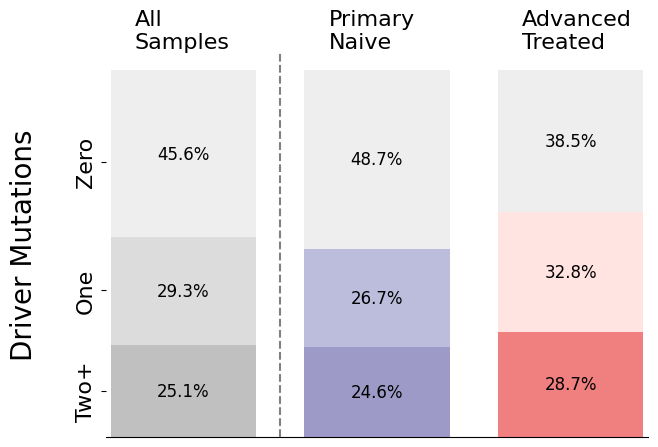

In [248]:
xlabels = ['All', 'Primary\nNaive', 'Advanced\nTreated']
ylabels = ['0', '20', '40', '60', '80', '100']
tab20c_cols = sns.color_palette("tab20c")
mycolors = tab20c_cols[-7:-4]#[::-1]

drivers_counts_low_subs = drivers_counts_low.loc[['All', 'Primary-Naive', 'Advanced-Treated']].copy()
drivers_counts_low_subs = drivers_counts_low_subs[['Two+', 'One', 'Zero']]

#fig, axes = plt.subplots(1,2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]}, sharey=True)
fig, axes = plt.subplots(figsize=(7, 5))#, facecolor='#f4f0eb')

ax2 = drivers_counts_low_subs.plot.bar(stacked=True, color=mycolors, ax=axes, width=0.75, fontsize=16)
#ax2.set_xticks(ticks=[0,1,2], labels=xlabels)
ax2.set_xticks(ticks=[], labels=[])
ax2.set_yticks(ticks=[0.125,0.4,0.75], labels=['Two+', 'One', 'Zero'], rotation=90, verticalalignment='center')
ax2.axvline(x=0.5, ls='--', color='grey')
#ax2.axvline(x=2.5, ls='--', color='grey')

ann_y = 1.06
fs = 16
ax2.text(-0.25, ann_y, 'All\nSamples', fontsize=fs)
ax2.text(0.75, ann_y, 'Primary\nNaive', fontsize=fs)
ax2.text(1.75, ann_y, 'Advanced\nTreated', fontsize=fs)
#ax2.set_facecolor('#f4f0eb')

#plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='Drivers', fontsize=14)
plt.xlim(-0.4,2.4)

labels2 = [f'{i:.1%}' for i in drivers_counts_low_subs.to_numpy().flatten(order='F')]
for i, patch in enumerate(ax2.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height() / 2
    if i in (6,7,8):
        patch.set_facecolor('#eeeeee')
    elif i == 3:
        patch.set_facecolor('gainsboro')
    elif i == 0:
        patch.set_facecolor('silver')
    elif i == 5:
        patch.set_facecolor('mistyrose')
    elif i == 2:
        patch.set_facecolor('lightcoral')
    
    ax2.annotate(labels2[i], (x, y), ha='center', va='center', c='black', fontsize=12)
ax2.spines[['right', 'top', 'left']].set_visible(False)
ax2.get_legend().remove()

plt.ylabel('Driver Mutations\n', fontsize=20)
#plt.savefig(os.path.join(fig_out, 'Fig_2b.pdf'), bbox_inches="tight")

Text(0, 0.5, 'Driver Mutations\n')

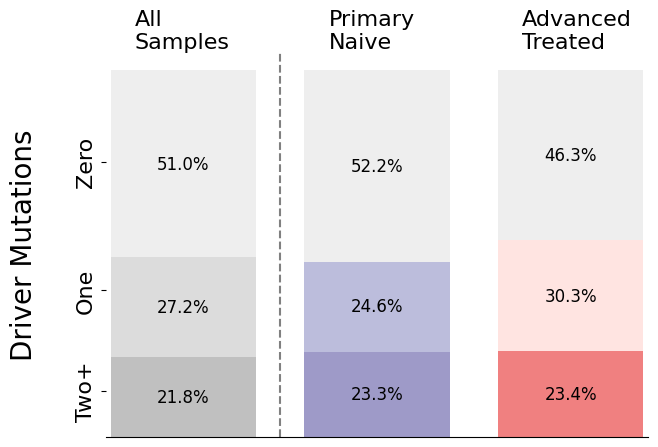

In [41]:
xlabels = ['All', 'Primary\nNaive', 'Advanced\nTreated']
ylabels = ['0', '20', '40', '60', '80', '100']
tab20c_cols = sns.color_palette("tab20c")
mycolors = tab20c_cols[-7:-4]#[::-1]

drivers_counts_low_subs = drivers_counts_low_new.loc[['All', 'Primary-Naive', 'Advanced-Treated']].copy()
drivers_counts_low_subs = drivers_counts_low_subs[['Two+', 'One', 'Zero']]

#fig, axes = plt.subplots(1,2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]}, sharey=True)
fig, axes = plt.subplots(figsize=(7, 5))#, facecolor='#f4f0eb')

ax2 = drivers_counts_low_subs.plot.bar(stacked=True, color=mycolors, ax=axes, width=0.75, fontsize=16)
#ax2.set_xticks(ticks=[0,1,2], labels=xlabels)
ax2.set_xticks(ticks=[], labels=[])
ax2.set_yticks(ticks=[0.125,0.4,0.75], labels=['Two+', 'One', 'Zero'], rotation=90, verticalalignment='center')
ax2.axvline(x=0.5, ls='--', color='grey')
#ax2.axvline(x=2.5, ls='--', color='grey')

ann_y = 1.06
fs = 16
ax2.text(-0.25, ann_y, 'All\nSamples', fontsize=fs)
ax2.text(0.75, ann_y, 'Primary\nNaive', fontsize=fs)
ax2.text(1.75, ann_y, 'Advanced\nTreated', fontsize=fs)
#ax2.set_facecolor('#f4f0eb')

#plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='Drivers', fontsize=14)
plt.xlim(-0.4,2.4)

labels2 = [f'{i:.1%}' for i in drivers_counts_low_subs.to_numpy().flatten(order='F')]
for i, patch in enumerate(ax2.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height() / 2
    if i in (6,7,8):
        patch.set_facecolor('#eeeeee')
    elif i == 3:
        patch.set_facecolor('gainsboro')
    elif i == 0:
        patch.set_facecolor('silver')
    elif i == 5:
        patch.set_facecolor('mistyrose')
    elif i == 2:
        patch.set_facecolor('lightcoral')
    
    ax2.annotate(labels2[i], (x, y), ha='center', va='center', c='black', fontsize=12)
ax2.spines[['right', 'top', 'left']].set_visible(False)
ax2.get_legend().remove()

plt.ylabel('Driver Mutations\n', fontsize=20)
#plt.savefig(os.path.join(fig_out, 'Fig_2b.pdf'), bbox_inches="tight")